<a href="https://colab.research.google.com/github/vincentjunitio00/FUTURE-Project-1/blob/main/%5BBlibli_Future_Data_Track%5D%20Supervised%20Learning%20-%20Estimated%20delivery%20difference%20day%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Frame the problem

Objective: to create a supervised learning model to predict the estimated delivery date by considering the real delivered day.

#2. Import data and library

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
real_data = pd.read_csv('https://raw.githubusercontent.com/vincentjunitio00/FUTURE-Project-1/main/bq1_final.csv')

In [3]:
display(real_data)

,fact_key,order_id,order_item_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day
0,1,00010242fe8c5a6d1ba2dd792cb16214,1.0,58900.0,13290.0,delivered,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,t,3,1,f,8,59,2,t,f,f,f,t,t,f,f,7.0,15
1,2,00018f77f2f0320c557190d7a144bdd3,1.0,239900.0,19930.0,delivered,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,t,10,4,f,10,53,6,f,t,f,f,t,f,f,f,16.0,18
2,3,000229ec398224ef6ca0657da4fc703e,1.0,199000.0,17870.0,delivered,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,f,7,3,f,14,33,31,f,f,t,f,t,f,f,f,7.0,21
3,4,00024acbcdf0a6daa1e931b038114c75,1.0,12990.0,12790.0,delivered,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,t,2,1,f,10,0,35,f,t,f,f,t,f,f,f,6.0,11
4,5,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,199900.0,18140.0,delivered,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,f,8,3,f,13,57,51,f,t,f,f,t,f,t,f,25.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,113421,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,unavailable,1.0,blipay,1.0,210090.0,NaN,NaN,NaN,NaN,NaN,BANTEN,NaN,16,1,2,t,7,3,f,14,27,59,f,f,t,f,t,f,f,f,NaN,20
113421,113422,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,canceled,1.0,voucher,1.0,63890.0,NaN,NaN,NaN,NaN,NaN,JAWA TENGAH,NaN,31,8,5,t,2,1,t,16,13,44,f,f,t,f,t,f,f,f,NaN,30
113422,113423,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,canceled,1.0,voucher,1.0,107130.0,NaN,NaN,NaN,NaN,NaN,BANTEN,NaN,6,9,4,t,3,1,f,18,45,47,f,f,f,t,f,f,f,t,NaN,20
113423,113424,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,NaN,unavailable,1.0,credit_card,2.0,195910.0,NaN,NaN,NaN,NaN,NaN,DKI JAKARTA,NaN,23,8,3,t,2,1,f,16,28,4,f,f,t,f,t,f,f,f,NaN,22


Take a quick look at its data structure.

In [4]:
real_data.head()

,fact_key,order_id,order_item_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day
0,1,00010242fe8c5a6d1ba2dd792cb16214,1.0,58900.0,13290.0,delivered,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,t,3,1,f,8,59,2,t,f,f,f,t,t,f,f,7.0,15
1,2,00018f77f2f0320c557190d7a144bdd3,1.0,239900.0,19930.0,delivered,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,t,10,4,f,10,53,6,f,t,f,f,t,f,f,f,16.0,18
2,3,000229ec398224ef6ca0657da4fc703e,1.0,199000.0,17870.0,delivered,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,f,7,3,f,14,33,31,f,f,t,f,t,f,f,f,7.0,21
3,4,00024acbcdf0a6daa1e931b038114c75,1.0,12990.0,12790.0,delivered,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,t,2,1,f,10,0,35,f,t,f,f,t,f,f,f,6.0,11
4,5,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,199900.0,18140.0,delivered,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,f,8,3,f,13,57,51,f,t,f,f,t,f,t,f,25.0,40


In [5]:
data = real_data.copy()

In [6]:
# Create a new feature called total item.
created_data = data[['order_id', 'order_item_id']].groupby('order_id').agg('count').rename(columns={'order_item_id': 'total_item'}) 
display(created_data)

,total_item
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
00018f77f2f0320c557190d7a144bdd3,1
000229ec398224ef6ca0657da4fc703e,1
00024acbcdf0a6daa1e931b038114c75,1
00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...
fffc94f6ce00a00581880bf54a75a037,1
fffcd46ef2263f404302a634eb57f7eb,1
fffce4705a9662cd70adb13d4a31832d,1


In [7]:
data_merged = data.merge(created_data, how='left', left_on=data.order_id, right_on=created_data.index)

In [8]:
data_merged.head()

,key_0,fact_key,order_id,order_item_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
0,00010242fe8c5a6d1ba2dd792cb16214,1,00010242fe8c5a6d1ba2dd792cb16214,1.0,58900.0,13290.0,delivered,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,t,3,1,f,8,59,2,t,f,f,f,t,t,f,f,7.0,15,1
1,00018f77f2f0320c557190d7a144bdd3,2,00018f77f2f0320c557190d7a144bdd3,1.0,239900.0,19930.0,delivered,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,t,10,4,f,10,53,6,f,t,f,f,t,f,f,f,16.0,18,1
2,000229ec398224ef6ca0657da4fc703e,3,000229ec398224ef6ca0657da4fc703e,1.0,199000.0,17870.0,delivered,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,f,7,3,f,14,33,31,f,f,t,f,t,f,f,f,7.0,21,1
3,00024acbcdf0a6daa1e931b038114c75,4,00024acbcdf0a6daa1e931b038114c75,1.0,12990.0,12790.0,delivered,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,t,2,1,f,10,0,35,f,t,f,f,t,f,f,f,6.0,11,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,5,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,199900.0,18140.0,delivered,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,f,8,3,f,13,57,51,f,t,f,f,t,f,t,f,25.0,40,1


In [9]:
data_merged_processed = data_merged.drop(['key_0', 'fact_key', 'order_item_id'], axis=1) # Remove unused features.
display(data_merged_processed)

,order_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
0,00010242fe8c5a6d1ba2dd792cb16214,58900.0,13290.0,delivered,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,t,3,1,f,8,59,2,t,f,f,f,t,t,f,f,7.0,15,1
1,00018f77f2f0320c557190d7a144bdd3,239900.0,19930.0,delivered,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,t,10,4,f,10,53,6,f,t,f,f,t,f,f,f,16.0,18,1
2,000229ec398224ef6ca0657da4fc703e,199000.0,17870.0,delivered,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,f,7,3,f,14,33,31,f,f,t,f,t,f,f,f,7.0,21,1
3,00024acbcdf0a6daa1e931b038114c75,12990.0,12790.0,delivered,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,t,2,1,f,10,0,35,f,t,f,f,t,f,f,f,6.0,11,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199900.0,18140.0,delivered,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,f,8,3,f,13,57,51,f,t,f,f,t,f,t,f,25.0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,unavailable,1.0,blipay,1.0,210090.0,NaN,NaN,NaN,NaN,NaN,BANTEN,NaN,16,1,2,t,7,3,f,14,27,59,f,f,t,f,t,f,f,f,NaN,20,0
113421,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,canceled,1.0,voucher,1.0,63890.0,NaN,NaN,NaN,NaN,NaN,JAWA TENGAH,NaN,31,8,5,t,2,1,t,16,13,44,f,f,t,f,t,f,f,f,NaN,30,0
113422,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,canceled,1.0,voucher,1.0,107130.0,NaN,NaN,NaN,NaN,NaN,BANTEN,NaN,6,9,4,t,3,1,f,18,45,47,f,f,f,t,f,f,f,t,NaN,20,0
113423,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,unavailable,1.0,credit_card,2.0,195910.0,NaN,NaN,NaN,NaN,NaN,DKI JAKARTA,NaN,23,8,3,t,2,1,f,16,28,4,f,f,t,f,t,f,f,f,NaN,22,0


In [10]:
data_ready = data_merged_processed.drop_duplicates()
data_ready.head()

,order_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
0,00010242fe8c5a6d1ba2dd792cb16214,58900.0,13290.0,delivered,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,t,3,1,f,8,59,2,t,f,f,f,t,t,f,f,7.0,15,1
1,00018f77f2f0320c557190d7a144bdd3,239900.0,19930.0,delivered,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,t,10,4,f,10,53,6,f,t,f,f,t,f,f,f,16.0,18,1
2,000229ec398224ef6ca0657da4fc703e,199000.0,17870.0,delivered,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,f,7,3,f,14,33,31,f,f,t,f,t,f,f,f,7.0,21,1
3,00024acbcdf0a6daa1e931b038114c75,12990.0,12790.0,delivered,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,t,2,1,f,10,0,35,f,t,f,f,t,f,f,f,6.0,11,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199900.0,18140.0,delivered,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,f,8,3,f,13,57,51,f,t,f,f,t,f,t,f,25.0,40,1


# 3. Quick cleaning and processing (not feature selection)

Select the 'delivered' order_status and 'delivered_diff_day' which is not NaN (np.nan).

Rename 'f' as 0 (false) and 't' as 1 (true).

Drop order_id and order_status (all status are delivered).

In [11]:
data_clean = data_ready[(data_ready['order_status'] == 'delivered') & (data_ready['delivered_diff_day'] != np.nan)].replace({'f': 0, 't': 1}).drop(['order_id', 'order_status'], axis = 1)
data_clean.head()

,price,shipping_cost,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
0,58900.0,13290.0,1.0,credit_card,2.0,72190.0,cool_stuff,650.0,28.0,9.0,14.0,JAWA TIMUR,BENGKULU,13,9,3,1,3,1,0,8,59,2,1,0,0,0,1,1,0,0,7.0,15,1
1,239900.0,19930.0,1.0,credit_card,3.0,259830.0,pet_shop,30000.0,50.0,30.0,40.0,NUSA TENGGARA TIMUR,BANTEN,26,4,3,1,10,4,0,10,53,6,0,1,0,0,1,0,0,0,16.0,18,1
2,199000.0,17870.0,1.0,credit_card,5.0,216870.0,furniture_decor,3050.0,33.0,13.0,33.0,PAPUA,SUMATERA SELATAN,14,1,7,0,7,3,0,14,33,31,0,0,1,0,1,0,0,0,7.0,21,1
3,12990.0,12790.0,1.0,credit_card,2.0,25780.0,perfumery,200.0,16.0,10.0,15.0,JAWA TENGAH,JAWA TENGAH,8,8,3,1,2,1,0,10,0,35,0,1,0,0,1,0,0,0,6.0,11,1
4,199900.0,18140.0,1.0,credit_card,3.0,218040.0,garden_tools,3750.0,35.0,40.0,30.0,KALIMANTAN BARAT,NUSA TENGGARA TIMUR,4,2,6,0,8,3,0,13,57,51,0,1,0,0,1,0,1,0,25.0,40,1


# 4. Check data type

In [12]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99978 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    99978 non-null  float64
 1   shipping_cost            99978 non-null  float64
 2   payment_sequential       99977 non-null  float64
 3   payment_type             99977 non-null  object 
 4   payment_installments     99977 non-null  float64
 5   payment_value            99977 non-null  float64
 6   product_category         98559 non-null  object 
 7   product_weight_g         99962 non-null  float64
 8   product_length_cm        99962 non-null  float64
 9   product_height_cm        99962 non-null  float64
 10  product_width_cm         99962 non-null  float64
 11  customer_state           99978 non-null  object 
 12  seller_state             99978 non-null  object 
 13  order_day                99978 non-null  int64  
 14  order_month          

Check which features have missing values.

In [13]:
data_clean.isnull().sum()

price                         0
shipping_cost                 0
payment_sequential            1
payment_type                  1
payment_installments          1
payment_value                 1
product_category           1419
product_weight_g             16
product_length_cm            16
product_height_cm            16
product_width_cm             16
customer_state                0
seller_state                  0
order_day                     0
order_month                   0
order_day_of_week             0
order_weekday_flag            0
order_fiscal_month            0
order_fiscal_quarter          0
order_month_end_flag          0
order_hour                    0
order_minute                  0
order_second                  0
order_is_morning              0
order_is_noon                 0
order_is_afternoon            0
order_is_night                0
order_is_office_hour          0
order_is_breakfast_time       0
order_is_lunch_time           0
order_is_dinner_time          0
delivere

#5. Handle missing values

Since product_category has many null values, then replace the null values with 'others'. Meanwhile, drop the other rows which have missing values.

In [14]:
data_full = data_clean.copy()
data_full['product_category'] = data_full['product_category'].fillna('others')

In [15]:
data_full = data_full.dropna(axis = 0)

In [16]:
data_full.isnull().sum()

price                      0
shipping_cost              0
payment_sequential         0
payment_type               0
payment_installments       0
payment_value              0
product_category           0
product_weight_g           0
product_length_cm          0
product_height_cm          0
product_width_cm           0
customer_state             0
seller_state               0
order_day                  0
order_month                0
order_day_of_week          0
order_weekday_flag         0
order_fiscal_month         0
order_fiscal_quarter       0
order_month_end_flag       0
order_hour                 0
order_minute               0
order_second               0
order_is_morning           0
order_is_noon              0
order_is_afternoon         0
order_is_night             0
order_is_office_hour       0
order_is_breakfast_time    0
order_is_lunch_time        0
order_is_dinner_time       0
delivered_diff_day         0
estimated_diff_day         0
total_item                 0
dtype: int64

#6. Understand data

In [17]:
data_full.describe()

,price,shipping_cost,payment_sequential,payment_installments,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
count,9.995300e+04,99953.000000,99953.000000,99953.000000,9.995300e+04,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000,99953.000000
mean,1.238926e+05,20082.072974,1.023431,2.953638,1.608642e+05,2088.747531,30.080728,16.383380,23.034726,15.529319,6.036667,3.758276,0.769562,6.770152,2.601723,0.029484,14.777635,29.521245,29.550079,0.099357,0.253049,0.434324,0.213270,0.591518,0.042270,0.061959,0.180335,12.033966,23.418627,1.194491
std,1.877507e+05,15793.297965,0.227763,2.741412,2.193926e+05,3741.992212,16.067464,13.273041,11.726586,8.665977,3.228716,1.967924,0.421116,3.653801,1.160408,0.169159,5.329986,17.296626,17.302970,0.299142,0.434761,0.495670,0.409619,0.491556,0.201205,0.241082,0.384468,9.534638,8.777760,0.643296
min,8.500000e+02,0.000000,1.000000,0.000000,0.000000e+00,0.000000,7.000000,2.000000,6.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,4.000000e+04,13140.000000,1.000000,1.000000,6.128000e+04,300.000000,18.000000,8.000000,15.000000,8.000000,3.000000,2.000000,1.000000,3.000000,1.000000,0.000000,11.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,18.000000,1.000000
50%,7.845000e+04,16320.000000,1.000000,2.000000,1.056300e+05,700.000000,25.000000,13.000000,20.000000,16.000000,6.000000,4.000000,1.000000,7.000000,3.000000,0.000000,15.000000,29.000000,30.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,10.000000,23.000000,1.000000
75%,1.390000e+05,21200.000000,1.000000,4.000000,1.790000e+05,1800.000000,38.000000,20.000000,30.000000,23.000000,8.000000,5.000000,1.000000,10.000000,4.000000,0.000000,19.000000,44.000000,45.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,15.000000,28.000000,1.000000
max,6.735000e+06,409680.000000,17.000000,24.000000,1.366408e+07,40425.000000,105.000000,105.000000,118.000000,31.000000,12.000000,7.000000,1.000000,12.000000,4.000000,1.000000,23.000000,59.000000,59.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,209.000000,155.000000,21.000000


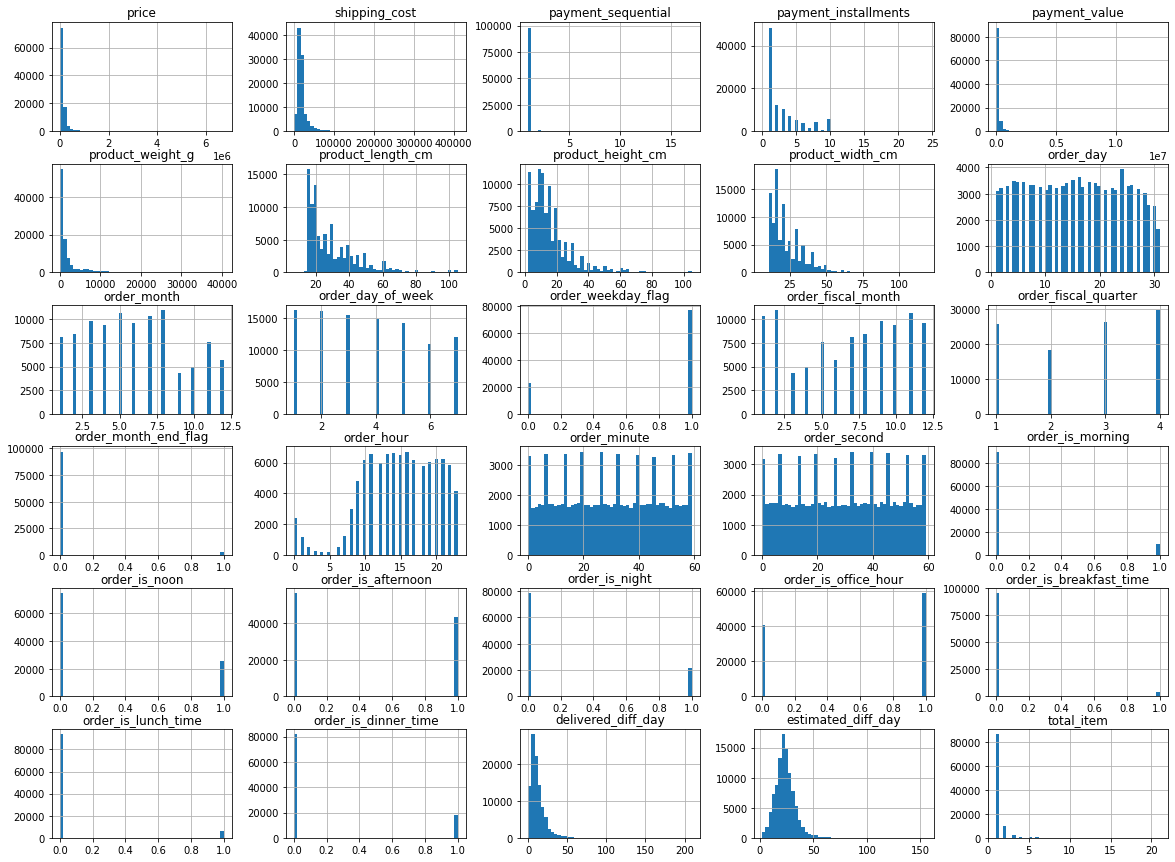

In [18]:
data_full.hist(bins=50, figsize=(20, 15))
plt.show()

Create a temporary feature to divide the delivered_label into classes.

In [19]:
data_full['delivered_label'] = pd.cut(data_full['delivered_diff_day'], bins=[-1, 6., 10., 15., np.inf], labels=[0, 1, 2, 3])

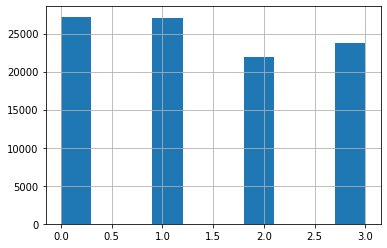

In [20]:
data_full['delivered_label'].hist()

Split the training, validation, and test set with the same ratio for each class.

First split the training-validation and test set.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

data_full = data_full.reset_index(drop=True)
split = StratifiedShuffleSplit(test_size=0.05, random_state=42)
for train_index, test_index in split.split(data_full.drop('delivered_label', axis=1), data_full['delivered_label']):
  strat_train_set = data_full.loc[train_index]
  strat_test_set = data_full.loc[test_index]

Next, split the training and validation set.

In [22]:
strat_train_set = strat_train_set.reset_index(drop=True)

split = StratifiedShuffleSplit(test_size=0.1, random_state=42)
for train_index, val_index in split.split(strat_train_set.drop('delivered_label', axis=1), strat_train_set['delivered_label']):
  strat_train_train_set = strat_train_set.loc[train_index]
  strat_val_set = strat_train_set.loc[val_index]

In [23]:
strat_val_set['delivered_label'].value_counts() / len(strat_val_set)

0    0.272220
1    0.270746
3    0.238311
2    0.218724
Name: delivered_label, dtype: float64

In [24]:
train = strat_train_train_set.reset_index(drop=True)
val = strat_val_set.reset_index(drop=True)
test = strat_test_set.reset_index(drop=True)

Remove the temporary feature.

In [25]:
# Remove the delivered labels
for set_ in (train, val, test):
  set_.drop("delivered_label", axis=1, inplace=True)

In [26]:
train.head()

,price,shipping_cost,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
0,89900.0,13650.0,1.0,blipay,1.0,103550.0,home_confort,1825.0,53.0,10.0,40.0,BANTEN,KALIMANTAN TIMUR,31,8,4,1,2,1,1,22,31,26,0,0,0,1,0,0,0,0,8.0,18,1
1,24500.0,15100.0,1.0,credit_card,2.0,39600.0,consoles_games,150.0,16.0,12.0,12.0,JAWA BARAT,RIAU,5,11,7,0,5,2,0,21,58,39,0,0,0,1,0,0,0,0,11.0,23,1
2,12000.0,15230.0,1.0,credit_card,2.0,27230.0,electronics,161.0,19.0,8.0,17.0,MALUKU,BANTEN,6,6,3,1,12,4,0,20,45,13,0,0,0,1,0,0,0,1,8.0,35,1
3,12900.0,18230.0,1.0,credit_card,1.0,31130.0,electronics,175.0,22.0,13.0,17.0,LAMPUNG,BANTEN,19,5,6,0,11,4,0,11,9,56,0,1,0,0,1,0,0,0,16.0,23,1
4,35000.0,19440.0,1.0,debit_card,1.0,54440.0,party_supplies,1350.0,30.0,4.0,36.0,JAWA TIMUR,JAWA BARAT,13,7,5,1,1,1,0,0,3,22,0,0,0,1,0,0,0,0,7.0,20,1


In [27]:
train.shape

(85459, 34)

In [28]:
val.shape

(9496, 34)

In [29]:
test.shape

(4998, 34)

#7. Visualize the data

Check the outliers.

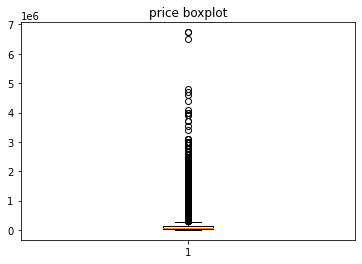

In [30]:
def plot_boxplot(df, column):
  """ To create the boxplot.
  Parameters:
  df: the dataframe
  column: the feature to be plot

  Return:
  The boxplot
  """
  plt.title(column + ' boxplot')
  plt.boxplot(df[column])
  plt.show()

plot_boxplot(train, 'price')

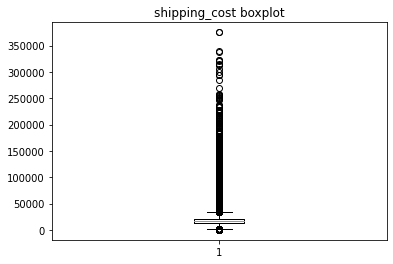

In [31]:
plot_boxplot(train, 'shipping_cost')

#8. Check the correlations

In [32]:
# Find the correlation. Correlation matrix show the dependency of an attribute with others
corr_matrix = train.corr()

corr_matrix['delivered_diff_day'].sort_values(ascending=False)

delivered_diff_day         1.000000
estimated_diff_day         0.380271
shipping_cost              0.210104
product_weight_g           0.075674
order_fiscal_month         0.068364
payment_value              0.063763
product_length_cm          0.062693
order_fiscal_quarter       0.059991
price                      0.058973
product_height_cm          0.055586
payment_installments       0.048210
product_width_cm           0.036315
order_day_of_week          0.028077
order_is_afternoon         0.007063
order_is_office_hour       0.007053
order_is_lunch_time        0.004938
order_month_end_flag       0.004035
order_is_noon              0.002565
payment_sequential         0.001972
order_minute               0.001800
order_second               0.000607
order_weekday_flag        -0.001844
order_day                 -0.002355
order_is_dinner_time      -0.003389
order_is_night            -0.005490
order_hour                -0.006198
order_is_morning          -0.007915
order_is_breakfast_time   -0

#9. Feature Engineering

In [33]:
trial = train.copy()
trial.corr()['delivered_diff_day'].sort_values(ascending=False)

delivered_diff_day         1.000000
estimated_diff_day         0.380271
shipping_cost              0.210104
product_weight_g           0.075674
order_fiscal_month         0.068364
payment_value              0.063763
product_length_cm          0.062693
order_fiscal_quarter       0.059991
price                      0.058973
product_height_cm          0.055586
payment_installments       0.048210
product_width_cm           0.036315
order_day_of_week          0.028077
order_is_afternoon         0.007063
order_is_office_hour       0.007053
order_is_lunch_time        0.004938
order_month_end_flag       0.004035
order_is_noon              0.002565
payment_sequential         0.001972
order_minute               0.001800
order_second               0.000607
order_weekday_flag        -0.001844
order_day                 -0.002355
order_is_dinner_time      -0.003389
order_is_night            -0.005490
order_hour                -0.006198
order_is_morning          -0.007915
order_is_breakfast_time   -0

In [34]:
trial['product_volume'] = trial['product_length_cm'] * trial['product_width_cm'] * trial['product_height_cm']
trial['order_time'] = trial['order_hour'] + (trial['order_minute'] / 60) + (trial['order_second'] / 3600)
trial['order_daytime'] = np.argmax(trial[['order_is_morning', 'order_is_noon', 'order_is_afternoon', 'order_is_night']].values, axis=1)
trial['meal_daytime'] = np.argmax(trial[['order_is_breakfast_time', 'order_is_lunch_time', 'order_is_dinner_time']].values, axis = 1)
trial['intra_inter_state'] = np.where(trial['customer_state'] == trial['seller_state'], 1, 0)

In [35]:
trial.corr()['delivered_diff_day'].sort_values(ascending=False)

delivered_diff_day         1.000000
estimated_diff_day         0.380271
shipping_cost              0.210104
product_weight_g           0.075674
order_fiscal_month         0.068364
product_volume             0.067683
payment_value              0.063763
product_length_cm          0.062693
order_fiscal_quarter       0.059991
price                      0.058973
product_height_cm          0.055586
payment_installments       0.048210
product_width_cm           0.036315
order_day_of_week          0.028077
order_is_afternoon         0.007063
order_is_office_hour       0.007053
order_is_lunch_time        0.004938
order_month_end_flag       0.004035
order_is_noon              0.002565
payment_sequential         0.001972
order_minute               0.001800
order_daytime              0.001526
order_second               0.000607
meal_daytime              -0.001823
order_weekday_flag        -0.001844
order_day                 -0.002355
order_is_dinner_time      -0.003389
order_is_night            -0

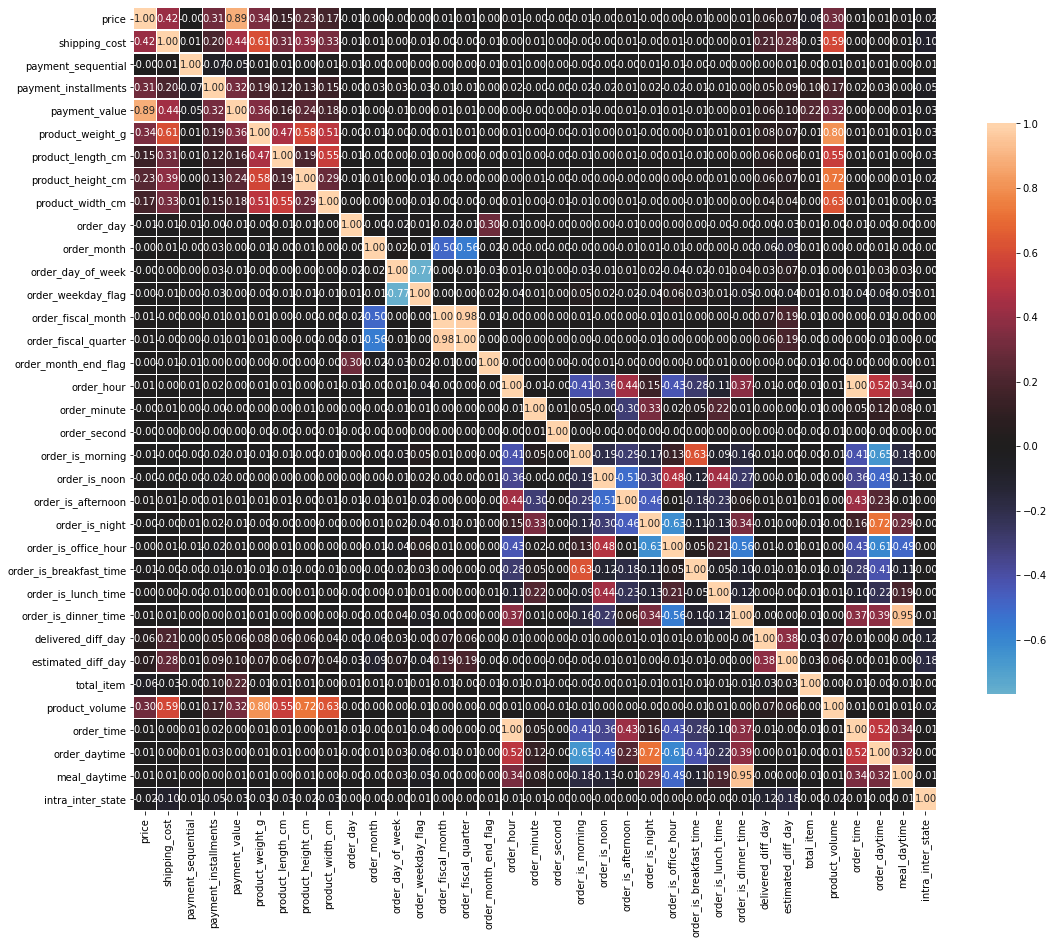

In [36]:
def correlation_heatmap(train, method):
  """ To create a correlation heatmap.
  Parameters:
  train: the dataframe
  method: the correlation method

  Return:
  The correlation plot
  """
  correlations = train.corr(method)

  fig, ax = plt.subplots(figsize=(18,15))
  sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
              square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
  plt.show();
    
correlation_heatmap(trial, 'pearson')

Remember that estimated_diff_day is not supposed to be considered unless the test set.

In [37]:
numerical_transform_features = ['product_width_cm', 'product_length_cm', 'product_height_cm']
# product_width_cm, product_length_cm, dan product_height_cm are used to create product_volume

# payment_value is used instead of price because payment_value is highly correlated with price
numerical_features = ['shipping_cost', 'product_weight_g', 'payment_value']

untransformed_features = ['payment_installments', 'order_fiscal_month', 'order_day_of_week', 'total_item', 'order_month']

state_features = ['customer_state', 'seller_state']

categorical_features = ['product_category', 'customer_state', 'seller_state']

target = ['delivered_diff_day', 'estimated_diff_day']

# 10. Normalization

Log transformation is used to normalize the data.

In [38]:
def log_transform(x):
  """ To perform log transformation.
  Parameter:
  x: the value to be transformed

  Return:
  transformed: the transformed value
  """
  transformed = np.where(x > 0.0, np.log(x), 0)
  return transformed

Fit in the function to transformer.

In [39]:
from sklearn.preprocessing import FunctionTransformer
np.seterr(divide = 'ignore')

ft = FunctionTransformer(log_transform)

ft.fit_transform(train[numerical_features])

array([[ 9.5214948 ,  7.50933527, 11.54780987],
       [ 9.62245002,  5.01063529, 10.5865844 ],
       [ 9.63102245,  5.08140436, 10.21207459],
       ...,
       [ 9.72615354,  8.13153071, 11.47978225],
       [11.11691552,  9.25435726, 12.65810322],
       [ 9.38008315,  6.2146081 , 10.70705741]])

#11. Data Cleaning
Since we drop all our null values, then continue to handling categorical data.

#12. Categorical attributes
All categorical features are transformed into one hot encoding.

#13. Build the pipelines

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

Build the first pipeline to create the product_volume feature and normalize it.

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class ProductVolumeAttributesAdder(BaseEstimator, TransformerMixin):
  """ To create the product volume feature """
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    product_volume = X['product_width_cm'] * X['product_length_cm'] * X['product_height_cm']
    return np.array(product_volume).reshape(-1, 1)

attr_adder = ProductVolumeAttributesAdder()
lala = attr_adder.transform(train[numerical_transform_features])

In [42]:
num_adder_pipeline = Pipeline([
                               ('product_volume_adder', ProductVolumeAttributesAdder()),
                               ('log_transform', FunctionTransformer(log_transform)),
                               ('rob_scaler', RobustScaler())
])

num_adder_pipeline.fit_transform(train[numerical_transform_features])

array([[ 0.651061  ],
       [-0.54532145],
       [-0.48349477],
       ...,
       [ 0.69732996],
       [ 1.22212859],
       [-0.18445296]])

Build the second pipeline to normalize the numerical features.

In [43]:
num_pipeline = Pipeline([
                         ('log_transform', FunctionTransformer(log_transform)),
                         ('rob_scaler', RobustScaler()) # kalau distance based itu perlu standardisasi
])

num_pipeline.fit_transform(train[numerical_features])

array([[-0.37444766,  0.53481226, -0.01728735],
       [-0.16284923, -0.85973875, -0.91252626],
       [-0.14488174, -0.82024178, -1.26132659],
       ...,
       [ 0.05450952,  0.88206615, -0.08064499],
       [ 2.96949545,  1.50872758,  1.01678618],
       [-0.67084128, -0.18778873, -0.80032352]])

Build the third pipeline to create the intra_inter_state feature.

In [44]:
class IntraInterAttributesAdder(BaseEstimator, TransformerMixin):
  """ To create the intra inter class feature """
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    intra_inter_state = np.where(X['customer_state'] == X['seller_state'], 1, 0)
    return np.array(intra_inter_state).reshape(-1, 1)

state_pipeline = Pipeline([
                           ('state_feature', IntraInterAttributesAdder())
])
state_pipeline.fit_transform(train[state_features])

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Build the fourth pipeline to transform the categorical features into one hot encoding representation.

In [45]:
cat_pipeline = Pipeline([
                         ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

cat_pipeline.fit_transform(train[categorical_features])

<85459x140 sparse matrix of type '<class 'numpy.float64'>'
	with 256377 stored elements in Compressed Sparse Row format>

Build the fifth pipeline to add the untransformed features into the pipeline.

In [46]:
class UntransformedAttributesAdder(BaseEstimator, TransformerMixin):
  """ To add the untransformed features into the pipeline """
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    return np.array(X)

untransformed_pipeline = Pipeline([
                                   ('untransformed_attribute', UntransformedAttributesAdder())
])

untransformed_pipeline.fit_transform(train[untransformed_features])

array([[ 1.,  2.,  4.,  1.,  8.],
       [ 2.,  5.,  7.,  1., 11.],
       [ 2., 12.,  3.,  1.,  6.],
       ...,
       [ 1.,  1.,  3.,  1.,  7.],
       [ 8.,  2.,  5.,  1.,  8.],
       [ 4.,  5.,  2.,  1., 11.]])

#14. Combine the pipelines

Connect all the pipelines into a whole pipeline.

In [47]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
                                   ('num_adder', num_adder_pipeline, numerical_transform_features),
                                   ('num', num_pipeline, numerical_features),
                                   ('state', state_pipeline, state_features),
                                   ('untransformed', untransformed_pipeline, untransformed_features),
                                   ('cat', cat_pipeline, categorical_features)
])

X_train = full_pipeline.fit_transform(train)
y_train = train[target]['delivered_diff_day']

In [48]:
X_train.shape

(85459, 150)

#15. Train the models

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor # Sama decision tree cuman banyak, ada parameter yang bisa dibatasi
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [50]:
X_val = full_pipeline.transform(val)
y_val = val[target]['delivered_diff_day']

In [51]:
# Before tuning
# xgb = XGBRegressor(random_state = 42, objective='reg:squarederror')
# xgb.fit(X_train, y_train)

# xgb_prediction = xgb.predict(X_val)
# mse = mean_squared_error(y_val, xgb_prediction)
# rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
# mae = mean_absolute_error(y_val, xgb_prediction)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("MAE: ", mae)

#16. Hyperparameter Tuning

The hyperparameter tuning process takes approximately 4 hours to finish.

In [52]:
# random_state = 42
# objective = 'reg:squarederror'
# learning_rates = [0.1, 0.01]
# min_child_weights = [5, 7, 9]
# max_depths = [7, 9]
# subsamples = [0.7, 0.9]
# colsample_bytrees = [0.7, 0.9]
# n_estimatorss = [500, 700, 900]

In [53]:
# hyperparams = {}
# for learning_rate in learning_rates:
#   for max_depth in max_depths:
#     for min_child_weight in min_child_weights:
#       for subsample in subsamples:
#         for colsample_bytree in colsample_bytrees:
#           for n_estimators in n_estimatorss:
#             params = learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators
#             xgb = XGBRegressor(random_state = random_state, learning_rate = learning_rate, max_depth = max_depth, min_child_weight = min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, objective=objective)
#             xgb.fit(X_train, y_train)

#             xgb_prediction = xgb.predict(X_val)
#             rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
#             mae = mean_absolute_error(y_val, xgb_prediction)
#             metrics = [rmse, mae]

#             hyperparams[params] = metrics
#             print(hyperparams)

Search for the best hyperparameters which has the lowest MAE.

In [54]:
# np.argmin(np.array(list(hyperparams.values()))[:, 1])

In [55]:
# np.array(list(hyperparams.keys()))[128]

Retrain the model with the chosen hyperparameters.

In [56]:
# After tuning
xgb = XGBRegressor(random_state = 42, learning_rate = 0.01, max_depth = 9, min_child_weight = 7, subsample=0.9, colsample_bytree=0.7, n_estimators=900, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.44836144762738
RMSE:  8.090016158675295
MAE:  4.991124465873288


#17. Perform testing

In [57]:
X_test = full_pipeline.transform(test)
y_real = test[target]['delivered_diff_day']

In [58]:
y_test_prediction = xgb.predict(X_test)
y_test_prediction = np.ceil(y_test_prediction)

#18. Display the comparison of real data and predicted data.

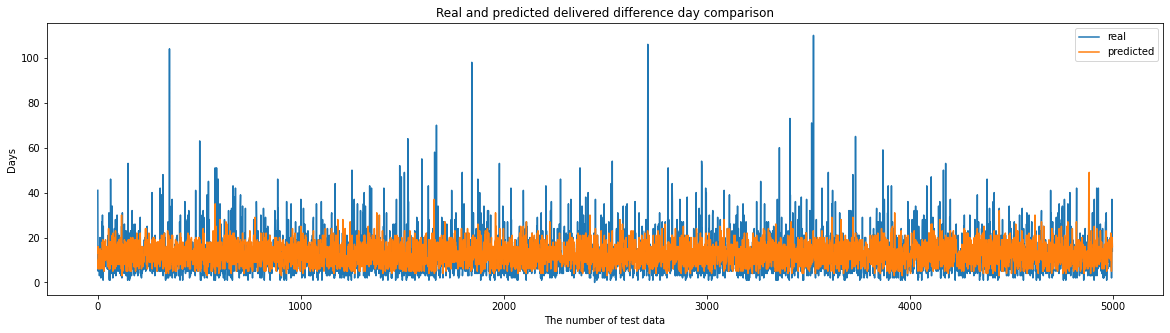

In [59]:
plt.figure(figsize=(20, 5))
plt.title('Real and predicted delivered difference day comparison')
plt.plot(np.arange(len(y_real)), y_real, label='real')
plt.plot(np.arange(len(y_test_prediction)), y_test_prediction, label='predicted')
plt.xlabel('The number of test data')
plt.ylabel('Days')
plt.legend()

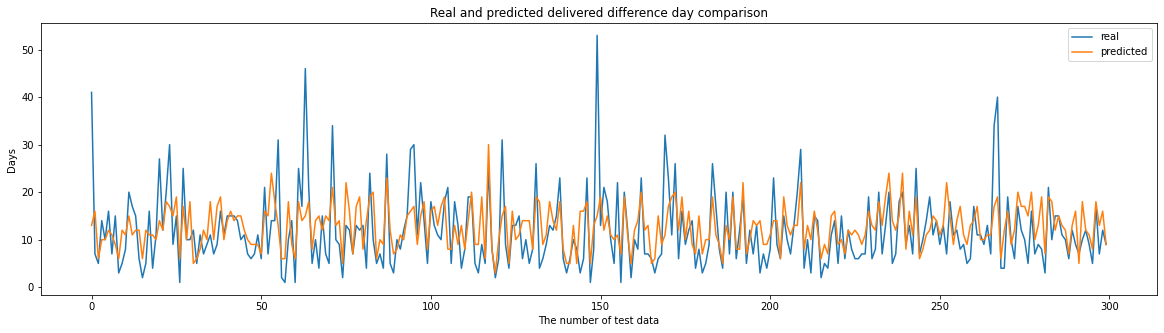

In [60]:
plt.figure(figsize=(20, 5))
plt.title('Real and predicted delivered difference day comparison')
plt.plot(np.arange(300), y_real[0:300], label='real')
plt.plot(np.arange(300), y_test_prediction[0:300], label='predicted')
plt.xlabel('The number of test data')
plt.ylabel('Days')
plt.legend()

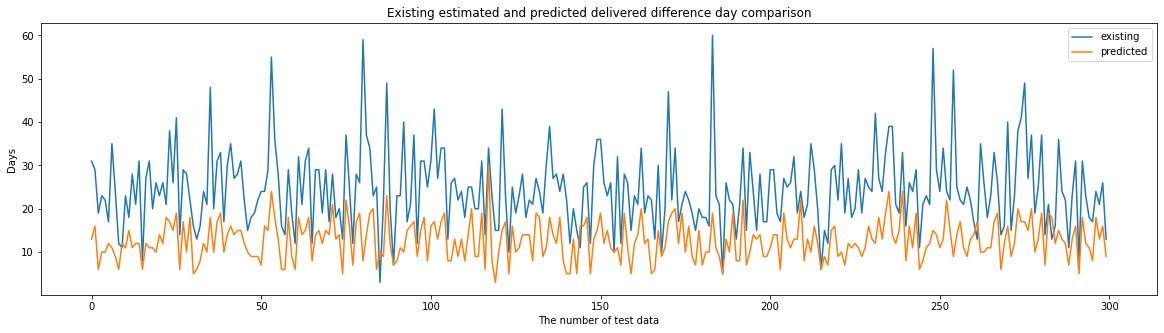

In [61]:
y_real_estimated = test[target]['estimated_diff_day']

plt.figure(figsize=(20, 5))
plt.title('Existing estimated and predicted delivered difference day comparison')
plt.plot(np.arange(300), y_real_estimated[0:300], label='existing')
plt.plot(np.arange(300), y_test_prediction[0:300], label='predicted')
plt.xlabel('The number of test data')
plt.ylabel('Days')
plt.legend()

# Not chosen machine learning models

In [ ]:
# linreg = LinearRegression()
# linreg.fit(X_train, y_train)

# linreg_prediction = linreg.predict(X_val)
# mse = mean_squared_error(y_val, linreg_prediction)
# rmse = np.sqrt(mean_squared_error(y_val, linreg_prediction))
# mae = mean_absolute_error(y_val, linreg_prediction)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("MAE: ", mae)

MSE:  79.25856523466865
RMSE:  8.902727965891614
MAE:  5.909481943083371


In [ ]:
# knr = KNeighborsRegressor()
# knr.fit(X_train, y_train)

# knr_prediction = knr.predict(X_val)
# mse = mean_squared_error(y_val, knr_prediction)
# rmse = np.sqrt(mean_squared_error(y_val, knr_prediction))
# mae = mean_absolute_error(y_val, knr_prediction)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("MAE: ", mae)

MSE:  80.68801244997778
RMSE:  8.982650636086086
MAE:  5.823654957759004


In [ ]:
# svr = SVR()
# svr.fit(X_train, y_train)

# svr_prediction = svr.predict(X_val)
# mse = mean_squared_error(y_val, svr_prediction)
# rmse = np.sqrt(mean_squared_error(y_val, svr_prediction))
# mae = mean_absolute_error(y_val, svr_prediction)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("MAE: ", mae)

In [ ]:
# rfr = RandomForestRegressor(random_state = 42)
# rfr.fit(X_train, y_train)

# rfr_prediction = rfr.predict(X_val)
# mse = mean_squared_error(y_val, rfr_prediction)
# rmse = np.sqrt(mean_squared_error(y_val, rfr_prediction))
# mae = mean_absolute_error(y_val, rfr_prediction)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("MAE: ", mae)

# XGBoost hyperparameter tuning parameters

XGB Documentation

https://towardsdatascience.com/boosting-performance-with-xgboost-b4a8deadede7

https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html

In [ ]:
xgb = XGBRegressor(random_state = 42, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  67.0426490618255
RMSE:  8.187957563509077
MAE:  5.216757512426525


In [ ]:
xgb1 = XGBRegressor(random_state = 42, learning_rate = 0.01, max_depth = 3, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb1.fit(X_train, y_train)

xgb1_prediction = xgb1.predict(X_val)
mse = mean_squared_error(y_val, xgb1_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb1_prediction))
mae = mean_absolute_error(y_val, xgb1_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  93.98199860704663
RMSE:  9.694431319424911
MAE:  5.74387913136654


In [ ]:
xgb2 = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 3, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb2.fit(X_train, y_train)

xgb2_prediction = xgb2.predict(X_val)
mse = mean_squared_error(y_val, xgb2_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb2_prediction))
mae = mean_absolute_error(y_val, xgb2_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  67.32742428292825
RMSE:  8.205329017347704
MAE:  5.235105607444947


In [ ]:
xgb3 = XGBRegressor(random_state = 42, learning_rate = 0.01, max_depth = 5, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb3.fit(X_train, y_train)

xgb3_prediction = xgb3.predict(X_val)
mse = mean_squared_error(y_val, xgb3_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb3_prediction))
mae = mean_absolute_error(y_val, xgb3_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  92.50900618327347
RMSE:  9.61816022861303
MAE:  5.690334863612895


In [ ]:
xgb4 = XGBRegressor(random_state = 42, learning_rate = 0.01, max_depth = 7, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb4.fit(X_train, y_train)

xgb4_prediction = xgb4.predict(X_val)
mse = mean_squared_error(y_val, xgb4_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb4_prediction))
mae = mean_absolute_error(y_val, xgb4_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  91.67763514735785
RMSE:  9.574843870651774
MAE:  5.657437266615456


In [ ]:
xgb5 = XGBRegressor(random_state = 42, learning_rate = 0.01, max_depth = 10, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb5.fit(X_train, y_train)

xgb5_prediction = xgb5.predict(X_val)
mse = mean_squared_error(y_val, xgb5_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb5_prediction))
mae = mean_absolute_error(y_val, xgb5_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  90.92615286353292
RMSE:  9.535520586917785
MAE:  5.6227927541086125


In [ ]:
xgb6 = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 5, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb6.fit(X_train, y_train)

xgb6_prediction = xgb6.predict(X_val)
mse = mean_squared_error(y_val, xgb6_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb6_prediction))
mae = mean_absolute_error(y_val, xgb6_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  66.011723971849
RMSE:  8.12475993318258
MAE:  5.141674861954604


In [ ]:
xgb7 = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb7.fit(X_train, y_train)

xgb7_prediction = xgb7.predict(X_val)
mse = mean_squared_error(y_val, xgb7_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb7_prediction))
mae = mean_absolute_error(y_val, xgb7_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.18257973453152
RMSE:  8.07357292247562
MAE:  5.087820724600312


In [ ]:
xgb8 = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 10, min_child_weight = 1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb8.fit(X_train, y_train)

xgb8_prediction = xgb8.predict(X_val)
mse = mean_squared_error(y_val, xgb8_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb8_prediction))
mae = mean_absolute_error(y_val, xgb8_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.12627959131878
RMSE:  8.070085476085044
MAE:  5.0926067198499565


Yes

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 3, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.35526402719027
RMSE:  8.084260264686577
MAE:  5.098302289081606


In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 5, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.73381714352183
RMSE:  8.107639431025644
MAE:  5.1072795368422925


In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 3, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Yes

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, subsample=0.7, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  64.72447339545597
RMSE:  8.045152167327599
MAE:  5.067440026969367


Yes

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, subsample=0.7, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  64.72447339545597
RMSE:  8.045152167327599
MAE:  5.067440026969367


Yes

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, subsample=0.7, colsample_bytree=0.5, n_estimators=100, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  66.74732006561334
RMSE:  8.169903308216893
MAE:  5.073442076747922


In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 1, subsample=0.7, colsample_bytree=0.5, n_estimators=200, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  66.37439571820136
RMSE:  8.147048282550028
MAE:  5.040293177349686


In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 7, min_child_weight = 7, subsample=0.9, colsample_bytree=0.5, n_estimators=500, objective='reg:squarederror')
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_val)
mse = mean_squared_error(y_val, xgb_prediction)
rmse = np.sqrt(mean_squared_error(y_val, xgb_prediction))
mae = mean_absolute_error(y_val, xgb_prediction)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  65.59696962204475
RMSE:  8.099195615741403
MAE:  5.000189771359471


https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning

In [ ]:
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.1],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [100, 200, 500],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = XGBRegressor(random_state=42)

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            scoring = 'neg_mean_absolute_error', #MAE
#                            #scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)

#     return gsearch.best_params_
  
# hyperParameterTuning(X_train, y_train)

# Run this to check the case when one order_id has two different products sales.

In [ ]:
data_ready[data_ready['order_id'] == '0008288aa423d2a3f00fcb17cd7d8719']

,order_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
13,0008288aa423d2a3f00fcb17cd7d8719,49900.0,13370.0,delivered,1.0,blipay,1.0,126540.0,garden_tools,1650.0,30.0,22.0,30.0,BALI,SUMATERA UTARA,13,2,2,t,8,3,f,22,10,21,f,f,t,f,f,f,f,f,12.0,20,2


In [ ]:
checker = pd.DataFrame(data_ready.groupby('order_id').agg('count')['total_item'])
checker[checker['total_item'] > 1]

,total_item
order_id,
002f98c0f7efd42638ed6100ca699b42,2
00337fe25a3780b3424d9ad7c5a4b35e,2
005d9a5423d47281ac463a968b3936fb,2
00946f674d880be1f188abc10ad7cf46,2
0097f0545a302aafa32782f1734ff71c,2
...,...
ffb18bf111fa70edf316eb0390427986,2
ffb8f7de8940249a3221252818937ecb,3
ffb9a9cd00c74c11c24aa30b3d78e03b,3


In [ ]:
data_ready[data_ready['order_id'] == '002f98c0f7efd42638ed6100ca699b42']

,order_id,price,shipping_cost,order_status,payment_sequential,payment_type,payment_installments,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,order_day,order_month,order_day_of_week,order_weekday_flag,order_fiscal_month,order_fiscal_quarter,order_month_end_flag,order_hour,order_minute,order_second,order_is_morning,order_is_noon,order_is_afternoon,order_is_night,order_is_office_hour,order_is_breakfast_time,order_is_lunch_time,order_is_dinner_time,delivered_diff_day,estimated_diff_day,total_item
80,002f98c0f7efd42638ed6100ca699b42,8990.0,32570.0,delivered,1.0,credit_card,9.0,93620.0,consoles_games,450.0,30.0,7.0,25.0,DKI JAKARTA,SUMATERA UTARA,4,8,5,t,2,1,f,9,19,10,t,f,f,f,t,f,f,f,3.0,31,2
81,002f98c0f7efd42638ed6100ca699b42,44900.0,7160.0,delivered,1.0,credit_card,9.0,93620.0,toys,200.0,16.0,7.0,11.0,DKI JAKARTA,BANTEN,4,8,5,t,2,1,f,9,19,10,t,f,f,f,t,f,f,f,3.0,31,2
